# Analysis 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.colors import LinearSegmentedColormap
import scipy.signal as ss
import matplotlib.animation as animation
from IPython.display import HTML

## Initial condition: dx = 0.1 dt = 0.05

In [2]:
dt = 0.05
dx = 0.1
h = 1.3*dx
data = pd.HDFStore('output.h5', mode ='r')
keylist=sorted(data.keys())
tmax = len(keylist)*dt

Text(0.5, 1.0, 'y position of the max free surface height without splash filter')

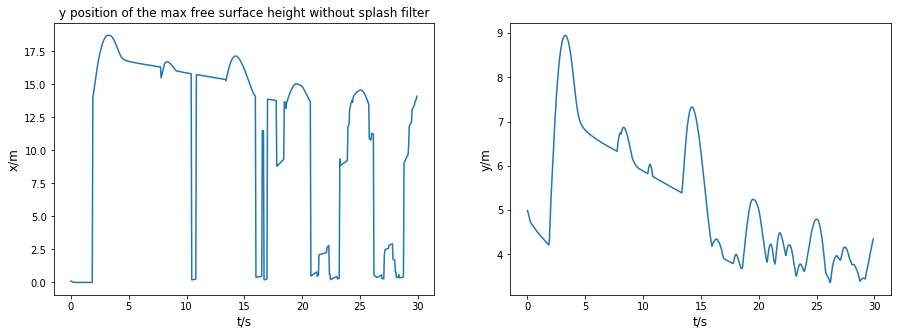

In [3]:
#without the spacing density filter
max_y = []
max_x =  []
t_list = []
for l in keylist:
    df = data.get(l)
    index = df.y.loc[df.types==0].idxmax()
    #print(df.y.iloc[index])
    max_y.append(df.y.iloc[index])
    max_x.append(df.x.iloc[index])
max_x = np.array(max_x)
max_y = np.array(max_y)

t = np.arange(0, tmax, dt)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(t, max_x)
axs[0].set_ylabel('x/m', fontsize=12)
axs[0].set_xlabel('t/s', fontsize=12)
axs[1].plot(t, max_y)
axs[1].set_ylabel('y/m', fontsize=12)
axs[1].set_xlabel('t/s', fontsize=12)
axs[0].set_title('x position of the max free surface height without splash filter')
axs[0].set_title('y position of the max free surface height without splash filter')

In [4]:
k1 = keylist[0]
df = data.get(k1)
liq = df.loc[df.types==0]
maxid = liq.y.idxmax() #find the top left liquid particle
max_x =liq.x.loc[maxid]
max_y =liq.y.loc[maxid]
print('Reference point:',max_x, max_y)
#set this as a threthold to distinguish between splash or surface
n_min = round(len(liq.loc[(liq.y>max_y-2*h) & (liq.y<max_y)])/10)
print('Minimum neighbour wanted:',n_min)

Reference point: 0.09881 4.987978
Minimum neighbour wanted: 9


The refrence point is the point have the maximum y value at the starting time with minium x. The above commands are calculating the number of neighbour of this point and use 10% of its number of neighbour as a reference thershold.

In [5]:
#without the spacing density filter
y_peak = []
x_peak =  []
t_list = []
for l in keylist:
    df = data.get(l)
    liq = df.loc[df.types==0]
    n = 0
    i = 0
    while (i<300 and n<n_min):
        maxid = liq.y.idxmax()
        max_x = liq.x.loc[maxid]
        max_y = liq.y.loc[maxid]
        #print(max_x, max_y)
        n = len(liq.loc[(liq.y>max_y-2*h) & (liq.y<max_y+2*h) & (liq.x>max_x-2*h) & (liq.x<max_x+2*h)])
        liq = liq.loc[liq.y<max_y]
        #print(n)
        mx = [max_x, max_y]
        i = i+1
    if i==300:
        print("hitting max itr")
    y_peak.append(max_y)
    x_peak.append(max_x)

y_peak=np.array(y_peak)
x_peak=np.array(x_peak)

In [6]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

plt.close()
init = data.get(keylist[0])
init_boundary = init.loc[init.types==1]
ax.plot(init_boundary.x, init_boundary.y,'.', markersize=2, color='grey')
xy, = ax.plot([],[],'.', markersize=2, color='green')
sqr, = ax.plot([],[],'k-')
maxpt, = ax.plot([],[],'.', markersize=2, color='red')
time_text = ax.text(0.78, 0.8, '', transform=ax.transAxes)

t_list = t
def init():
    xy.set_data([], [])
    sqr.set_data([], [])
    maxpt.set_data([], [])
    time_text.set_text('')
    return xy, time_text, sqr


def animate(i):
    update = data.get(keylist[i])
    square = [[x_peak[i]-2*h, x_peak[i]+2*h, x_peak[i]+2*h, x_peak[i]-2*h, x_peak[i]-2*h],
              [y_peak[i]-2*h, y_peak[i]-2*h, y_peak[i]+2*h, y_peak[i]+2*h, y_peak[i]-2*h]]
    sqr.set_data(square[0], square[1])
    liquid = update.loc[update.types==0]
    xy.set_data(liquid.x, liquid.y)
    maxpt.set_data(x_peak[i], y_peak[i])
    time_text.set_text('time = {0:.3f}'.format(t_list[i]))
    return xy, time_text, maxpt, sqr

frames = np.arange(0, 100, 1)
anim = animation.FuncAnimation(fig, animate, frames,
                             blit=True, init_func=init)

    
HTML(anim.to_jshtml())

Text(0.5, 1.0, 'y position of the max free surface height with splash filter')

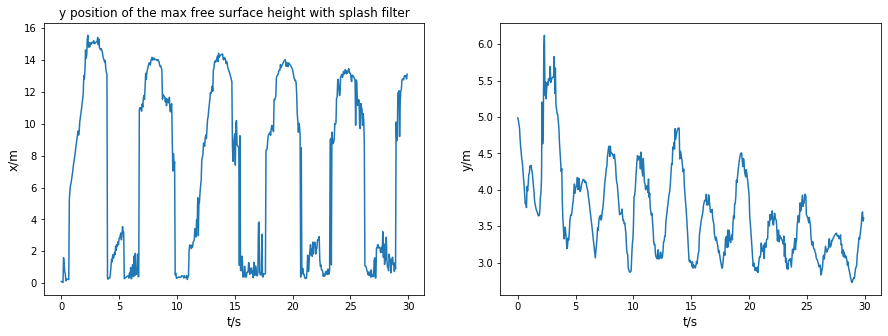

In [7]:
t = np.arange(0, tmax, dt)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(t, x_peak)
axs[1].plot(t, y_peak)

axs[0].set_ylabel('x/m', fontsize=12)
axs[0].set_xlabel('t/s', fontsize=12)
axs[1].set_ylabel('y/m', fontsize=12)
axs[1].set_xlabel('t/s', fontsize=12)
axs[0].set_title('x position of the max free surface height with splash filter')
axs[0].set_title('y position of the max free surface height with splash filter')

We can compare the wave partern with the normal boundary one. ![title](rect_boundary.png)
* More periods in 30s
* Smoother sloashing to the right bounday